# Synthetic MFBO model

The idea here is that we want to show a GP for both the high- and low-fidelity models as well as the "ground truth" objective function i.e. the actual structure-property relationship.

see [here](https://github.com/SimonEnsemble/BO_of_COFs/blob/main/synthetic_example.ipynb) for inspiration.

helpful link for legend formatting: [here](https://stackoverflow.com/questions/21570007/subheadings-for-categories-within-matplotlib-custom-legend)

In [1]:
import math
import torch
from torch.optim import Adam
import gpytorch
from botorch import fit_gpytorch_model
from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from botorch.acquisition.analytic import ExpectedImprovement
from torch.distributions import Normal


sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine(top=True, right=True)

<Figure size 432x288 with 0 Axes>

In [2]:
# pal = sns.color_palette('Set2')
# pal.as_hex()[1]

# cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA',
#                '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']

### The Objective Function 

In [3]:
def f(x):
    return x * torch.exp(-4*x) + torch.sin(3*x*math.pi)*torch.exp(-2* x)

ground_x = torch.linspace(0, 1, 100)
ground_y = f(ground_x)

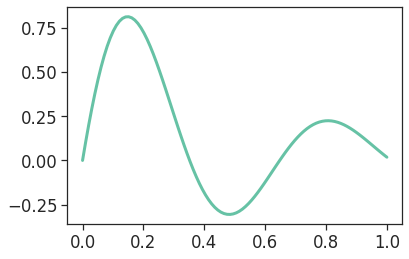

In [4]:
plt.figure()
plt.plot(ground_x, ground_y)

## The Surrogate Model

Note: The surrogate model is a multi-fidelity Gaussian Process (GP), and the lower fidelity may be less accurate. I am modeling this by adding a small random noise to the function values.

In [5]:
###
#  Generate Initial Training Set
#  lf_ => low-fidelity
#  hf_ => high-fidelity
###
gp_models = dict({'lf_model': dict.fromkeys(['train_x', 'train_y', 'model', 'likelihood']), 
                  'hf_model': dict.fromkeys(['train_x', 'train_y', 'model', 'likelihood'])
                 })

gp_models['lf_model']['train_x'] = torch.tensor([0.01, 0.2, 0.45, 0.6, 0.73, 0.93])
torch.manual_seed(0) # for reproducibility
random_noise = torch.rand(len(gp_models['lf_model']['train_x'])) / 10  # low_fidelity approx. error
gp_models['lf_model']['train_y'] = f(gp_models['lf_model']['train_x']) + random_noise

gp_models['hf_model']['train_x'] = torch.tensor([0.15, 0.6, 0.93])
gp_models['hf_model']['train_y'] = f(gp_models['hf_model']['train_x'])

In [6]:
###
#  Simple GP Model
###
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


for fidelity_model in gp_models:
    train_x = gp_models[fidelity_model]['train_x']
    train_y = gp_models[fidelity_model]['train_y']
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = 1e-4 # sets the value to zero
    likelihood.noise_covar.raw_noise.requires_grad = False # optimizer won't optimize noise hyper-parameter.
    model = ExactGPModel(train_x, train_y, likelihood)

    ###
    #  Fit/Train Model Using Data
    ###
    model.train()

    # Use the Adam optimizer
    optimizer = Adam([{'params': model.parameters()},  ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    training_iter = 100
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
    # store model and likelihood
    gp_models[fidelity_model]['model'] = model
    gp_models[fidelity_model]['likelihood'] = likelihood
    
# take a look at the results
gp_models

{'lf_model': {'train_x': tensor([0.0100, 0.2000, 0.4500, 0.6000, 0.7300, 0.9300]),
  'train_y': tensor([ 0.1515,  0.8042, -0.2790, -0.1094,  0.2007,  0.1814]),
  'model': ExactGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
  'likelihood': GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )},
 'hf_model': {'train_x': tensor([0.1500, 0.6000, 0.9300]),
  'train_y': tensor([ 0.8140, -0.1226,  0.1180]),
  'model': ExactGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )

In [7]:
###
#  Plotting Figure 3 in the Paper
###
fid_mkr  = ["+", "x"]

fig = plt.figure(figsize=(12, 10), dpi=1200) 
# dummy used for legend padding
plt_handles = []

p_empty, = plt.plot([0], marker='None', linestyle='None', label='')

# with torch.no_grad():
#     # plot objective function
#     plt.plot(ground_x.numpy(), ground_y.numpy(), linestyle="--", 
#              color="C2", label='truth, $f(x)$', lw=3)

for i, fidelity_model in zip([0,1], gp_models.keys()):
    color = "C{}".format(i)
    
    train_x    = gp_models[fidelity_model]['train_x']
    train_y    = gp_models[fidelity_model]['train_y']
    model      = gp_models[fidelity_model]['model']
    likelihood = gp_models[fidelity_model]['likelihood']

    model.eval()
    likelihood.eval()
    
    
    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, 1, 100)
        observed_pred = likelihood(model(test_x))
    
    
    with torch.no_grad():
        # Initialize plot
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as scatter
        p_sc = plt.plot(train_x.numpy(), train_y.numpy(), marker=fid_mkr[i], 
                          color=color, linestyle='None',
                          label='observations $\{(x_i, y^{(\ell={%d})}_i)\}$'%i, 
                          markersize=22, mew=4, zorder=i+1, lw=10)
        # needed for legend
        plt_handles.append(p_sc)

        # Plot predictive means as line
        p_ln = plt.plot(test_x.numpy(), observed_pred.mean.numpy(), color=color, 
                        label='model, $\hat{y}^{(\ell={%d})}(x)$'%i, lw=4)
        # Shade between the lower and upper confidence bounds
        plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), 
                         alpha=0.15, color=color, edgecolor="none", zorder=i)
        # needed for legend
        plt_handles.append(p_ln)
        
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlim([0, 1])
    plt.ylim([-1.2, 1.2])
    plt.xlabel('COF feature space, $x$', fontsize=34)
    plt.ylabel('property, $y$', fontsize=34)
    plt.yticks([])
    plt.xticks([])
    the_ylims = plt.gca().get_ylim()

    
    
    
sur_models = [r'$\hat{y}^{(\ell=0)}(x)$', r'$\hat{y}^{(\ell=1)}(x)$']
obs = [r'$\{(x_i, y^{(\ell=0)}_i)\}$', r'$\{(x_i, y^{(\ell=1)}_i)\}$']

leg = plt.legend([p_empty, plt_handles[1][0], plt_handles[3][0], 
                  p_empty, plt_handles[0][0], plt_handles[2][0]], 
                 ["models"] + sur_models + ["observations"] + obs, 
                 loc=(0.002, 0.002), ncol=2, fontsize=32) # Two columns, horizontal group labels

fig.add_artist(leg)
plt.tight_layout()
plt.savefig("multi_fdelity_gp_synthetic_example.pdf", format="pdf")